<a href="https://colab.research.google.com/gist/ramayer/a9a6c4e397c71e3a5c12e594c0f3c1ea/5-compare-ssqueezepy-s-wavelets-vs-librosa-s-stft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare ssqueezepy's wavelets vs librosa's stft

* I can make cleaner images of rumbles using ssqueezepy's synchrosqueezed wavelets than I can using stft's.
* However it's significantly slower.






In [ ]:
import os
os.environ.get('COLAB_RELEASE_TAG')

'release-colab_20240514-060118_RC01'

In [ ]:
if os.environ.get('COLAB_RELEASE_TAG'):
  from google.colab import drive
  drive.mount('/content/drive')
  !ls -l '/content/drive/MyDrive/AI for Forest Elephants 2 Shared' data
  %pip install --quiet ssqueezepy
else:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lrw------- 1 root root  0 May 17 13:13 '/content/drive/MyDrive/AI for Forest Elephants 2 Shared' -> '/content/drive/.shortcut-targets-by-id/1I5LUAPjKN2p4vsrFWr-_Mya-XmVFv2eL/AI for Forest Elephants 2 Shared'
lrwxrwxrwx 1 root root 55 May 17 12:59  data -> '/content/drive/MyDrive/AI for Forest Elephants 2 Shared'


In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import ssqueezepy as sqz
from ssqueezepy.experimental import scale_to_freq


In [ ]:
prefix = './data/01. Data/cornell_data/Rumble/Training/'
path,duration,offset = (prefix + 'Sounds/CEB1_20111010_000000.wav',60,0)
path,duration,offset = (prefix + 'Sounds/ceb1_20110103_000000.wav',30,74506.563)

audio, sr = librosa.load(path, sr=None, duration=duration, offset=offset)

def plot_db(spec_in_db, title=None, ylabel="frequency bin"):
    fig, axs = plt.subplots(1, 1,figsize=(10, 6))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec_in_db, aspect="auto",cmap='magma')
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

## Almost the original cell from Visualizing Spectrograms

* changed the y_axis to a log scale so the rumble is more than a couple pixels tall

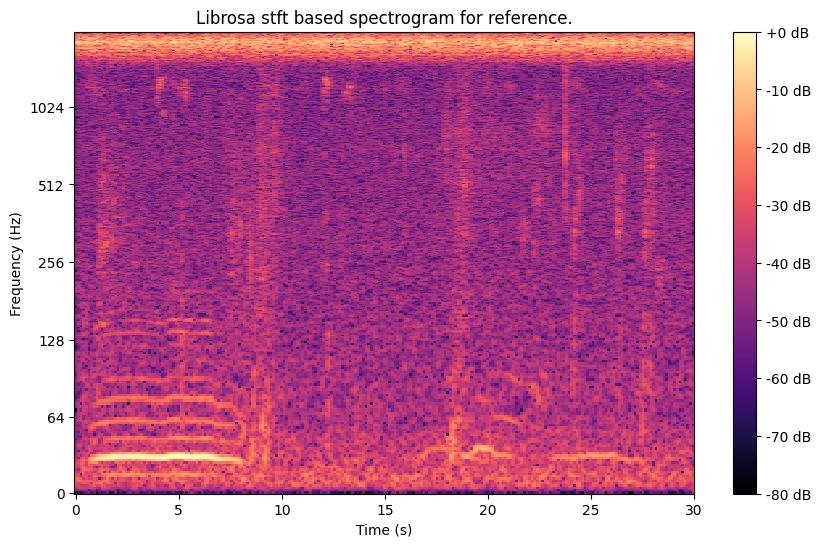

In [ ]:
# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(audio)

# Convert the amplitude to decibels
S_DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plotting the Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Librosa stft based spectrogram for reference.')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## ssqueezpy's ssq_cwt

* much cleaner without even having to pick parameters like n_fft, window_size, etc.

In [ ]:
wavelet = sqz.Wavelet()

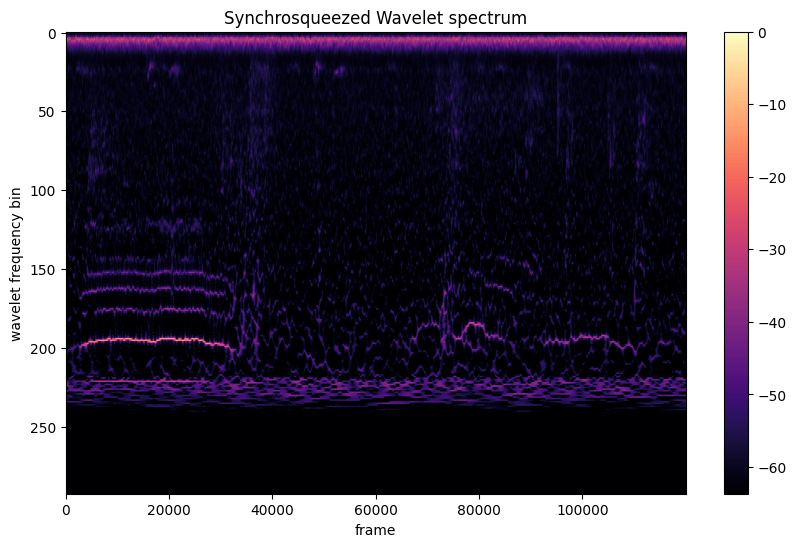

In [ ]:

def try_ssqueezepy_wavelet(audio):
  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales='log-piecewise',cache_wavelet=True)
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  db = librosa.amplitude_to_db(np.abs(Tx),ref=np.max)
  plot_db(db,ylabel="wavelet frequency bin",title="Synchrosqueezed Wavelet spectrum")

try_ssqueezepy_wavelet(audio)

## Try ssqueezepy's `imshow` to see if it looks even better?

* Not really

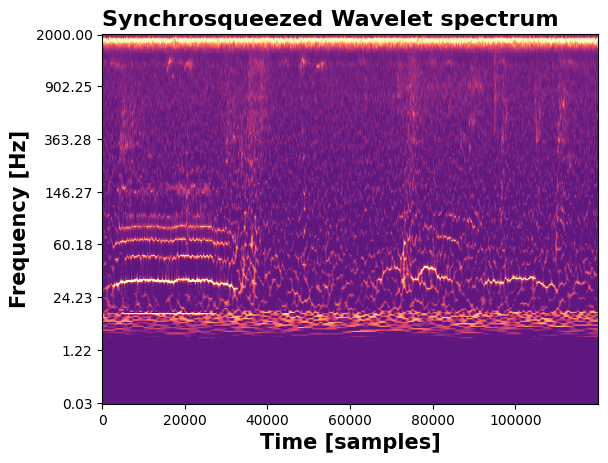

In [ ]:
def try_ssqueezepy_wavelet(audio):
  wavelet = sqz.Wavelet()
  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales='log-piecewise')
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  db = librosa.amplitude_to_db(np.abs(Tx),ref=np.max)
  #plot_db(db,ylabel="wavelet frequency bin")
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  ikw = dict(norm=(-75,-35),xlabel="Time [samples]", ylabel="Frequency [Hz]", yticks=freqs_cwt)
  sqz.imshow(db, **ikw,cmap='magma', title='Synchrosqueezed Wavelet spectrum')

try_ssqueezepy_wavelet(audio)

## Show ssqueezepy's wavelet API without synchrosqueezing

* as fuzzy as I'd expect.

cwt (293, 120000)


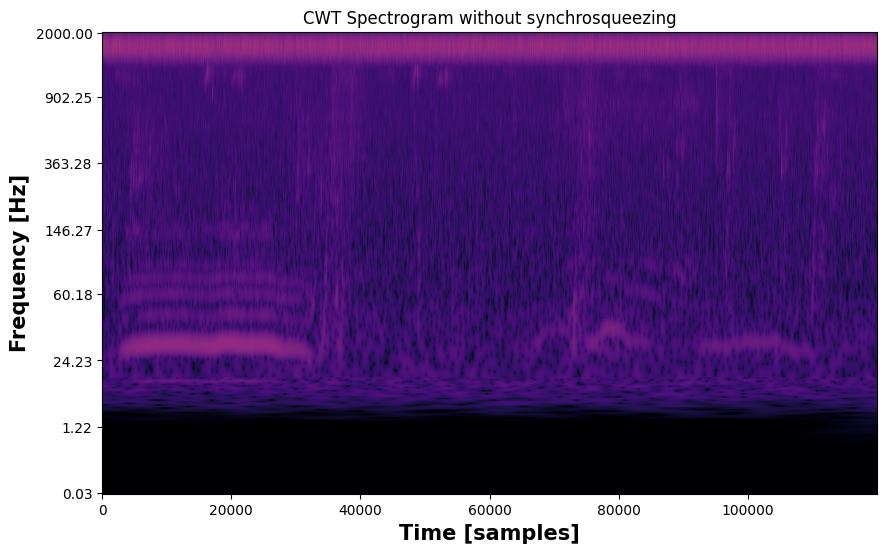

In [ ]:
import ssqueezepy as sqz
from ssqueezepy.experimental import scale_to_freq

def try_wavelet(audio):
  wavelet = sqz.Wavelet()
  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales='log-piecewise')
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  print("cwt",Tx.shape)

  # Convert to DB and plot the results
  db = librosa.amplitude_to_db(np.abs(Wx),ref=np.max)
  plt.figure(figsize=(10, 6))
  plt.title('CWT Spectrogram without synchrosqueezing')
  ikw = dict(xlabel="Time [samples]", ylabel="Frequency [Hz]", yticks=freqs_cwt)
  sqz.imshow(db, **ikw,cmap='magma')

try_wavelet(audio)

## Try ssqueezepy's stft API with synchrosqueezing

* Interesting, but not as clean as the wavelet version (at least with any parameters I've tried)

cwt (1025, 3750)


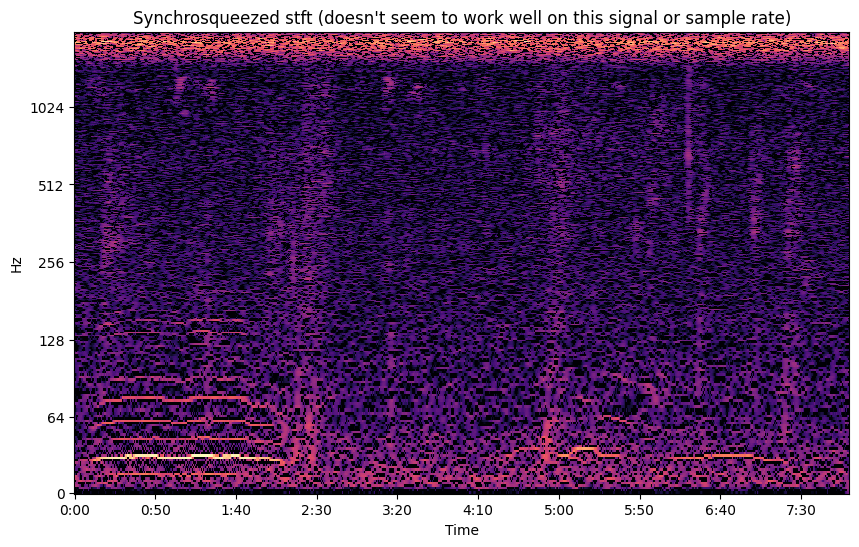

In [ ]:
import ssqueezepy as sqz
from ssqueezepy.experimental import scale_to_freq

def try_ssqueezepy_stft(audio):
  n_fft = 1024 * 2
  Tx, Wx, ssq_freqs, stft_freqs = sqz.ssq_stft(audio,n_fft=n_fft,hop_len=n_fft//64,window='hann')
  print("cwt",Tx.shape)

  # Convert to DB and plot the results
  db = librosa.amplitude_to_db(np.abs(Tx),ref=np.max)
  plt.figure(figsize=(10, 6))
  plt.title("Synchrosqueezed stft (doesn't seem to work well on this signal or sample rate)")
  ikw = dict(xlabel="Time [samples]", ylabel="Frequency [Hz]")#, yticks=stft_freqs)
  #sqz.imshow(db, **ikw,cmap='hot_r')
  librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')


try_ssqueezepy_stft(audio)

## Makes me suspect we'll want to have a multi-step classifier.  

The first, could be an extremely lightweight stft based one, that could work on a significantly downsampled version of the audio - maybe down to a 128Hz sample rate to make it as fast as possible --- and all it would try to do would be to say "is there any detectable low-frequency component that isn't just noise".  It could be tuned to try to minimize false negatives at the expense of many false positives.

The second could be a far more expensive model.   I'm wildly speculating that the best one will be an ensebmle of many of the various models attempted in this class.


In [ ]:
%pip install PyWavelets

In [ ]:
# -*- coding: utf-8 -*-
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import os
import numpy as np
import gc
import pandas as pd
import scipy.signal as sig
import librosa
from pywt import cwt as pcwt
from timeit import timeit as _timeit

from ssqueezepy import cwt, stft, ssq_cwt, ssq_stft, Wavelet
from ssqueezepy.utils import process_scales, padsignal
from ssqueezepy.ssqueezing import _compute_associated_frequencies

def timeit(fn, number=10):
    return _timeit(fn, number=number) / number

#%%# Bench funcs #############################################################
def print_report(header, times):
    print(("{}\n"
           "CWT:      {:.3f} sec\n"
           "STFT:     {:.3f} sec\n"
           "SSQ_CWT:  {:.3f} sec\n"
           "SSQ_STFT: {:.3f} sec\n"
           ).format(header, *list(times.values())[-4:]))

def time_ssq_cwt(x, dtype, scales, cache_wavelet, ssq_freqs):
    wavelet = Wavelet(dtype=dtype)
    kw = dict(wavelet=wavelet, scales=scales, ssq_freqs=ssq_freqs)
    if cache_wavelet:
        for _ in range(3):  # warmup run
            _ = ssq_cwt(x, cache_wavelet=True, **kw)
            del _; gc.collect()
    return timeit(lambda: ssq_cwt(x, cache_wavelet=cache_wavelet, **kw))

def time_ssq_stft(x, dtype, n_fft):
    for _ in range(3):
        _ = ssq_stft(x, dtype=dtype, n_fft=n_fft)
        del _; gc.collect()
    return timeit(lambda: ssq_stft(x, dtype=dtype, n_fft=n_fft))

def time_cwt(x, dtype, scales, cache_wavelet):
    wavelet = Wavelet(dtype=dtype)
    if cache_wavelet:
        for _ in range(3):  # warmup run
            _ = cwt(x, wavelet, scales=scales, cache_wavelet=True)
            del _; gc.collect()
    return timeit(lambda: cwt(x, wavelet, scales=scales,
                              cache_wavelet=cache_wavelet))

def time_stft(x, dtype, n_fft):
    for _ in range(3):
        _ = stft(x, dtype=dtype, n_fft=n_fft)
        del _; gc.collect()
    return timeit(lambda: stft(x, dtype=dtype, n_fft=n_fft))

def time_all(x, dtype, scales, cache_wavelet, ssq_freqs, n_fft):
    num = str(len(x))[:-3] + 'k'
    return {num: '',
            f'{num}-cwt':      time_cwt(x, dtype, scales, cache_wavelet),
            f'{num}-stft':     time_stft(x, dtype, n_fft),
            f'{num}-ssq_cwt':  time_ssq_cwt(x, dtype, scales, cache_wavelet,
                                            ssq_freqs),
            f'{num}-ssq_stft': time_ssq_stft(x, dtype, n_fft)
            }

#%%# Setup ###################################################################
# warmup
x = np.random.randn(1000)
for dtype in ('float32', 'float64'):
    wavelet = Wavelet(dtype=dtype)
    _ = ssq_cwt(x, wavelet, cache_wavelet=False)
    _ = ssq_stft(x, dtype=dtype)
del _, wavelet

#%%# Prepare reusable parameters such that STFT & CWT output shapes match ####
N0, N1 = 10000, 160000  # selected such that CWT pad length ratios are same
n_rows = 300
n_fft = n_rows * 2 - 2

wavelet = Wavelet()
scales = process_scales('log-piecewise', N1, wavelet=wavelet)[:n_rows]
ssq_freqs = _compute_associated_frequencies(
    scales, N1, wavelet, 'log-piecewise', maprange='peak',
    was_padded=True, dt=1, transform='cwt')

kw = dict(scales=scales, ssq_freqs=ssq_freqs, n_fft=n_fft)
t_all = {}

#%%# Baseline ################################################################
print("// BASELINE (dtype=float32, cache_wavelet=True)")

os.environ['SSQ_PARALLEL'] = '0'
os.environ['SSQ_GPU'] = '0'
t_all['base'] = {}
dtype = 'float32'

for N in (N0, N1):
    x = np.random.randn(N)
    t_all['base'].update(time_all(x, dtype=dtype, cache_wavelet=True, **kw))
    print_report(f"/ N={N}", t_all['base'])

#%%# Parallel + wavelet cache ################################################
print("// PARALLEL + CACHE (dtype=float32, cache_wavelet=True)")

os.environ['SSQ_PARALLEL'] = '1'
os.environ['SSQ_GPU'] = '0'
t_all['parallel'] = {}
for N in (N0, N1):
    x = np.random.randn(N)
    t_all['parallel'].update(time_all(x, dtype='float32', cache_wavelet=True,
                                      **kw))
    print_report(f"/ N={N}", t_all['parallel'])

#%%# GPU + wavelet cache #####################################################
print("// GPU + CACHE (dtype=float32, cache_wavelet=True)")

os.environ['SSQ_GPU'] = '1'
t_all['gpu'] = {}
for N in (N0, N1):
    x = np.random.randn(N)
    t_all['gpu'].update(time_all(x, dtype='float32', cache_wavelet=True, **kw))
    print_report(f"/ N={N}", t_all['gpu'])

#%%
df = pd.DataFrame(t_all)
print(df)

#%% PyWavelets ###############################################################
for N in (N0, N1):
    x = np.random.randn(N)
    xp = padsignal(x)
    t = timeit(lambda: pcwt(xp, wavelet='cmor1.5-1.0', scales=scales,
                            method='fft'))
    print("pywt_cwt-%s:" % N, t)

#%% Scipy
for N in (N0, N1):
    x = np.random.randn(N)
    xp = padsignal(x)
    t = timeit(lambda: sig.cwt(xp, wavelet=sig.morlet,
                               widths=np.arange(4, 4 + len(scales))))
    print("scipy_cwt-%s:" % N, t)

#%%
for N in (N0, N1):
    x = np.random.randn(N)
    t = timeit(lambda: sig.stft(x, nperseg=n_fft, nfft=n_fft, noverlap=n_fft-1))
    print("scipy_stft-%s:" % N, t)

#%% Librosa
# NOTE: we bench here with float64 since float32 is slower for librosa as of 0.8.0
for N in (N0, N1):
    x = np.random.randn(N)
    t = timeit(lambda: librosa.stft(x, n_fft=n_fft, hop_length=1, dtype='float64'))
    print("librosa_stft-%s:" % N, t)


// BASELINE (dtype=float32, cache_wavelet=True)
/ N=10000
CWT:      0.090 sec
STFT:     0.116 sec
SSQ_CWT:  0.286 sec
SSQ_STFT: 0.282 sec

/ N=160000
CWT:      2.702 sec
STFT:     1.414 sec
SSQ_CWT:  8.047 sec
SSQ_STFT: 7.308 sec

// PARALLEL + CACHE (dtype=float32, cache_wavelet=True)
/ N=10000
CWT:      0.080 sec
STFT:     0.073 sec
SSQ_CWT:  0.581 sec
SSQ_STFT: 0.268 sec



KeyboardInterrupt: 

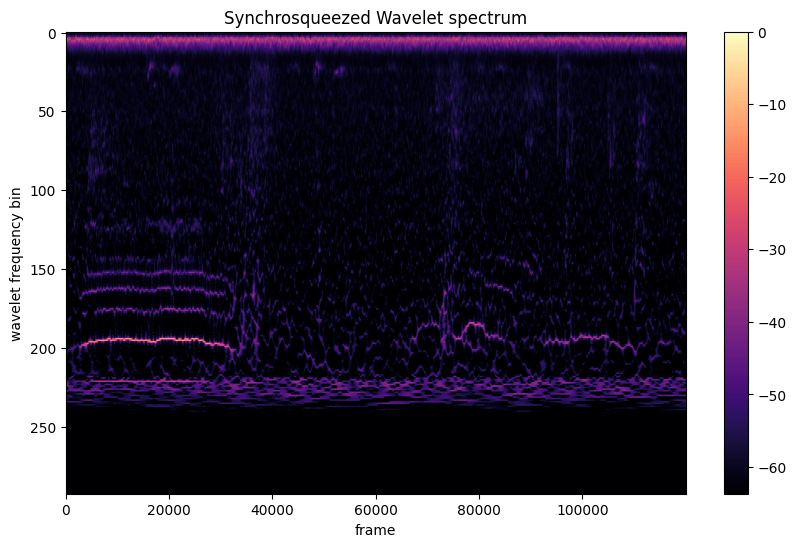

In [ ]:

def try_ssqueezepy_wavelet(audio):
  scales="log-piecewise"
  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales='log-piecewise',cache_wavelet=True)
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  db = librosa.amplitude_to_db(np.abs(Tx),ref=np.max)
  plot_db(db,ylabel="wavelet frequency bin",title="Synchrosqueezed Wavelet spectrum")

try_ssqueezepy_wavelet(audio)

In [ ]:
help(cwt)

Help on function cwt in module ssqueezepy._cwt:

cwt(x, wavelet='gmw', scales='log-piecewise', fs=None, t=None, nv=32, l1_norm=True, derivative=False, padtype='reflect', rpadded=False, vectorized=True, astensor=True, cache_wavelet=None, order=0, average=None, nan_checks=None, patience=0)
    Continuous Wavelet Transform. Uses FFT convolution via frequency-
    domain wavelets matching (padded) input's length.
    
    Uses `Wavelet.dtype` precision.
    
    # Arguments:
        x: np.ndarray / torch.Tensor
            Input vector(s), 1D / 2D.
    
            2D: does *not* do 2D CWT. Instead, treats dim0 as separate inputs,
            e.g. `(n_channels, time)`, improving speed & memory w.r.t. looping.
    
        wavelet: str / tuple[str, dict] / `wavelets.Wavelet`
            Wavelet sampled in Fourier frequency domain.
                - str: name of builtin wavelet. See `ssqueezepy.wavs()`
                  or `Wavelet.SUPPORTED`.
                - tuple: name of builtin wavelet

In [ ]:
# prompt: for the numpy array scales return a new array where each element has the value 1.5^(the_value_from_the_original)

scales_new = 1.5**scales


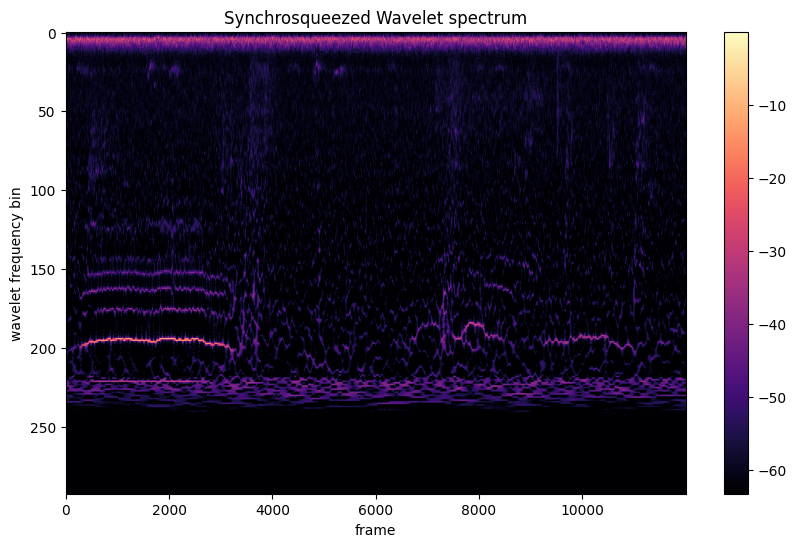

In [ ]:

def try_ssqueezepy_wavelet(audio):
  scales = 2.0 ** np.arange(0, 100, 1)
  scales="log-piecewise"

  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales=scales,cache_wavelet=True)
  Tx = Tx[:,::10]
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  db = librosa.amplitude_to_db(np.abs(Tx),ref=np.max)
  plot_db(db,ylabel="wavelet frequency bin",title="Synchrosqueezed Wavelet spectrum")

try_ssqueezepy_wavelet(audio)

cwt (99, 120000)


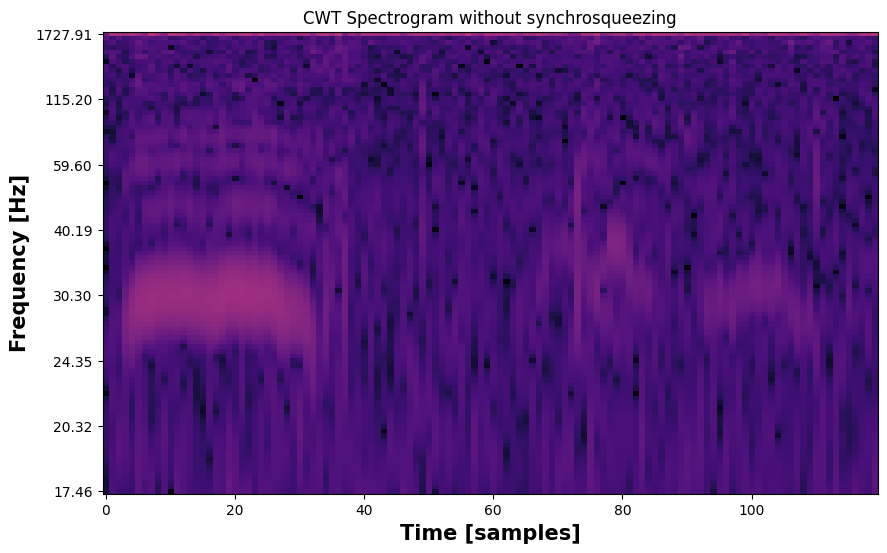

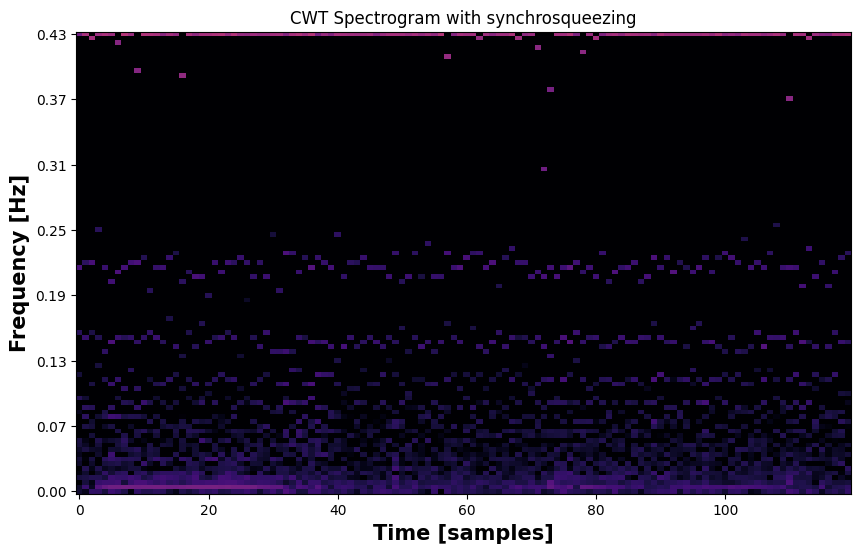

In [ ]:
import ssqueezepy as sqz
from ssqueezepy.experimental import scale_to_freq

def try_wavelet(audio):
  wavelet = sqz.Wavelet()
  try_scales = np.array([[x*1.0] for x in np.arange(1, 100, 1.0)])
  Tx, Wx, ssq_freqs, scales = sqz.ssq_cwt(audio, wavelet, scales=try_scales)

  #Wx, scales = sqz.cwt(audio, wavelet, scales=try_scales)
  freqs_cwt = scale_to_freq(scales, wavelet, len(audio), fs=sr)
  print("cwt",Wx.shape)

  # Convert to DB and plot the results
  db = librosa.amplitude_to_db(np.abs(Wx[:,::1000]),ref=np.max)
  plt.figure(figsize=(10, 6))
  plt.title('CWT Spectrogram without synchrosqueezing')
  ikw = dict(xlabel="Time [samples]", ylabel="Frequency [Hz]", yticks=freqs_cwt)
  sqz.imshow(db, **ikw,cmap='magma')

  plt.figure(figsize=(10, 6))
  plt.title('CWT Spectrogram with synchrosqueezing')

  db = librosa.amplitude_to_db(np.abs(Tx[:,::1000]),ref=np.max)
  ikw = dict(xlabel="Time [samples]", ylabel="Frequency [Hz]", yticks=ssq_freqs)
  sqz.imshow(db, **ikw,cmap='magma')

try_wavelet(audio)

In [ ]:
#scales.shape,np.min(scales),np.max(scales)
scales

array([[7.87990423e-01],
       [8.05245166e-01],
       [8.22877739e-01],
       [8.40896415e-01],
       [8.59309649e-01],
       [8.78126080e-01],
       [8.97354538e-01],
       [9.17004043e-01],
       [9.37083817e-01],
       [9.57603281e-01],
       [9.78572062e-01],
       [1.00000000e+00],
       [1.02189715e+00],
       [1.04427378e+00],
       [1.06714040e+00],
       [1.09050773e+00],
       [1.11438674e+00],
       [1.13878863e+00],
       [1.16372486e+00],
       [1.18920712e+00],
       [1.21524736e+00],
       [1.24185781e+00],
       [1.26905096e+00],
       [1.29683955e+00],
       [1.32523664e+00],
       [1.35425555e+00],
       [1.38390988e+00],
       [1.41421356e+00],
       [1.44518081e+00],
       [1.47682615e+00],
       [1.50916443e+00],
       [1.54221083e+00],
       [1.57598085e+00],
       [1.61049033e+00],
       [1.64575548e+00],
       [1.68179283e+00],
       [1.71861930e+00],
       [1.75625216e+00],
       [1.79470908e+00],
       [1.83400809e+00],
